<a href="https://colab.research.google.com/github/NeulboGom/J_Automation_Project/blob/JH/Anomaly_Classification_no_csv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

os.getcwd()

'/content'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from glob import glob
import cv2
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image
import pandas as pd
import csv
import numpy as np

# Image Crop

In [12]:
# (0, 0, 700, 700) -> (100, 100, 550, 550)
# 이미지 crop 범위를 줄여서 이미지 용량을 줄이는 효과 기대

root = './Dataset'
img_list = glob(os.path.join(root,'**/*.png'),recursive=True)
# glob 경로를 설정하여 리스트로 반환
for img in tqdm(img_list):
    img_data = Image.open(img)
    area = (100,100,550,550)
    cropped_img = img_data.crop(area)
    cropped_img.save(img)

0it [00:00, ?it/s]


### glob는 경로를 설정하고, 그 안에 있는 파일들을 리스트로 반환한다
### recursive를 False로 두면 그냥 그 경로만, True로 두면 하위 디렉토리까지

In [14]:
print("recursive = True 일 때")
glob_dir1 = glob('/content/Dataset', recursive = True)

for i in glob_dir1:
    print(i)
    print(type(i))
    print(glob_dir1)
    print(type(glob_dir1))

print()
print("recursive = False 일 때")

glob_dir2 = glob('/content/Dataset', recursive = False)

for i in glob_dir2:
    print(i)
    print(type(i))
    print(glob_dir2)
    print(type(glob_dir2))

recursive = True 일 때

recursive = False 일 때


## imshow를 이용한 이미지 출력

In [15]:
plt.imshow(cropped_img)

NameError: ignored

# Image to csv by numpy

In [ ]:
timage = cv2.imread('C://Users/cheer/DL/JAuto_Project/Dataset/good_up/1_153911.png')

print(type(timage))
print(timage)

print("Size info:", timage.shape)
print("height:", timage.shape[0])
print("info type:", type(timage.shape[0]))



### Test code

In [3]:
# 경로 안에 있는 모든 이미지를 데이터화하는 함수

def preprocess_image(image_path, target_size=(450, 450)):
    # 이미지 파일 경로 불러오기
    image_list = glob(os.path.join(image_path, '*.png'))

    # 빈 numpy 배열 생성
    img_array = np.empty((len(image_list), *target_size, 3), dtype=np.uint8)

    for i, img in enumerate(image_list):
        image = Image.open(img)
        image = image.resize(target_size)
        img_array[i] = np.array(image)[:, :, np.newaxis]

    return img_array


In [4]:
# 이미지 데이터화
processed_good_up = preprocess_image('/content/drive/MyDrive/Project/good_up')
processed_good_under = preprocess_image('/content/drive/MyDrive/Project/good_under')

# 처리된 이미지의 차원 출력
print(processed_good_up.shape)
print(processed_good_under.shape)

(74, 450, 450, 3)
(49, 450, 450, 3)


### Application

# 폐기

# Model Application

## ResNet Model 가져오기

In [5]:
import tensorflow as tf
import tensorflow.keras as keras

from keras import layers, Model, Input

# 모델 불러오기
model = keras.applications.resnet50.ResNet50(weights = None,
                                             include_top = True,
                                             input_tensor = Input(shape = (450, 450, 3)),
                                             classes = 4)

'''
include_top: 네트워크에 FC-layer를 넣을지 말지 Boolean (커스텀 할지 말지 여부 결정)
weights: 구조만 가져오고 싶으면 None, 아니면 default가 'imagenet'이기 때문에 속성 넣지 않기
input_tensor: 첫번째 Conv2D의 input_shape라 생각하면 됨 (선언 방법: keras.layers.Input(shape=(w, h, c)))
pooling: include_top이 False일 때 None, avg, max 중 선택
classes: include_top이 True이고 weights가 None일 때 커스텀으로 구별할 클래스(레이블)의 수
'''

"\ninclude_top: 네트워크에 FC-layer를 넣을지 말지 Boolean (커스텀 할지 말지 여부 결정)\nweights: 구조만 가져오고 싶으면 None, 아니면 default가 'imagenet'이기 때문에 속성 넣지 않기\ninput_tensor: 첫번째 Conv2D의 input_shape라 생각하면 됨 (선언 방법: keras.layers.Input(shape=(w, h, c)))\npooling: include_top이 False일 때 None, avg, max 중 선택\nclasses: include_top이 True이고 weights가 None일 때 커스텀으로 구별할 클래스(레이블)의 수\n"

## Model Compiling

In [35]:
from keras.optimizers import Adam

model.compile(optimizer = Adam(learning_rate = 0.0005),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'],)

## Train, Test data divide

In [7]:
from sklearn.model_selection import train_test_split

# 정상 up 이미지 로드
X_normal_up = preprocess_image('/content/drive/MyDrive/Project/good_up')
# 정상 under 이미지 로드
X_normal_under = preprocess_image('/content/drive/MyDrive/Project/good_under')
# 비정상 up 이미지 로드
X_abnormal_up = preprocess_image('/content/drive/MyDrive/Project/notgood_up')
# 비정상 under 이미지 로드
X_abnormal_under = preprocess_image('/content/drive/MyDrive/Project/notgood_under')

# 각 클래스에 대한 클래스 레이블 생성
# "정상 up" 클래스: 0
# "정상 under" 클래스: 1
# "비정상 up" 클래스: 2
# "비정상 under" 클래스: 3
y_normal_up = np.zeros(len(X_normal_up))
y_normal_under = np.ones(len(X_normal_under))
y_abnormal_up = np.full(len(X_abnormal_up), 2)
y_abnormal_under = np.full(len(X_abnormal_under), 3)

# 각 클래스별 데이터를 하나로 합치기
# X_up은 "정상 up"과 "비정상 up" 데이터를 하나로 합침
X_up = np.concatenate((X_normal_up, X_abnormal_up), axis=0)
# X_under -> "정상 under"과 "비정상 under" 데이터를 하나로 합침
X_under = np.concatenate((X_normal_under, X_abnormal_under), axis=0)
# y_up -> "정상 up"과 "비정상 up"을 하나로 합쳐서 y_up 안에는 0과 1 두 개의 레이블이 존재
y_up = np.concatenate((y_normal_up, y_abnormal_up), axis=0)
# y_under -> "정상 under"과 "비정상 under"을 하나로 합쳐서 y_under 안에는 0과 1 두 개의 레이블이 존재
y_under = np.concatenate((y_normal_under, y_abnormal_under), axis=0)

# 각 데이터를 Train, Validation, Test 데이터로 나누기
X_train_up, X_temp_up, y_train_up, y_temp_up = train_test_split(X_up, y_up, test_size=0.2, random_state=42)
X_val_up, X_test_up, y_val_up, y_test_up = train_test_split(X_temp_up, y_temp_up, test_size=0.5, random_state=42)

X_train_under, X_temp_under, y_train_under, y_temp_under = train_test_split(X_under, y_under, test_size=0.2, random_state=42)
X_val_under, X_test_under, y_val_under, y_test_under = train_test_split(X_temp_under, y_temp_under, test_size=0.5, random_state=42)


In [16]:
# 이미지 정규화
X_train_up = X_train_up / 255
X_val_up = X_val_up / 255
X_test_up = X_test_up / 255

X_train_under = X_train_under / 255
X_val_under = X_val_under / 255
X_test_under = X_test_under / 255

## CSV Dataframe to Image Data

## Model Train

In [23]:
EPOCH = 30
BATCH_SIZE = 3

# up 모델 훈련
history_up = model.fit(X_train_up, y_train_up,
                       epochs=EPOCH,
                       batch_size=BATCH_SIZE,
                       validation_data=(X_val_up, y_val_up),
                       verbose=1)

# under 모델 훈련
history_under = model.fit(X_train_under, y_train_under,
                          epochs=EPOCH,
                          batch_size=BATCH_SIZE,
                          validation_data=(X_val_under, y_val_under),
                          verbose=1)

Epoch 1/30
33/33 [==============================] - 12s 181ms/step - loss: 0.2630 - accuracy: 0.9192 - val_loss: 33.4927 - val_accuracy: 0.5833
Epoch 2/30
33/33 [==============================] - 5s 149ms/step - loss: 0.1018 - accuracy: 0.9596 - val_loss: 0.8640 - val_accuracy: 0.6667
Epoch 3/30
33/33 [==============================] - 5s 153ms/step - loss: 0.1316 - accuracy: 0.9394 - val_loss: 3.0531 - val_accuracy: 0.4167
Epoch 4/30
33/33 [==============================] - 5s 150ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 1.5717 - val_accuracy: 0.4167
Epoch 5/30
33/33 [==============================] - 5s 152ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.2827 - val_accuracy: 0.9167
Epoch 6/30
33/33 [==============================] - 5s 155ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0905 - val_accuracy: 1.0000
Epoch 7/30
33/33 [==============================] - 5s 158ms/step - loss: 9.3659e-04 - accuracy: 1.0000 - val_loss: 0.0259 - val_accuracy: 1.0000


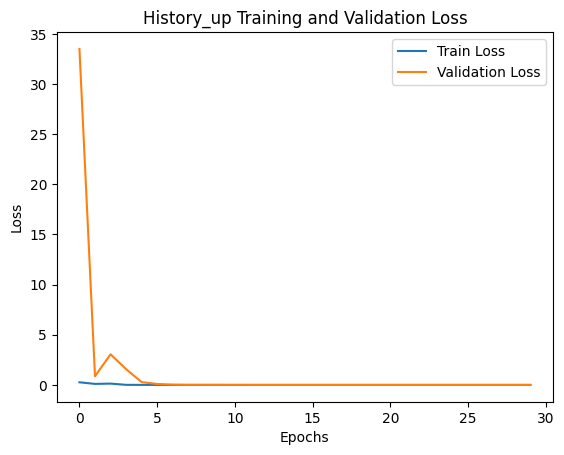

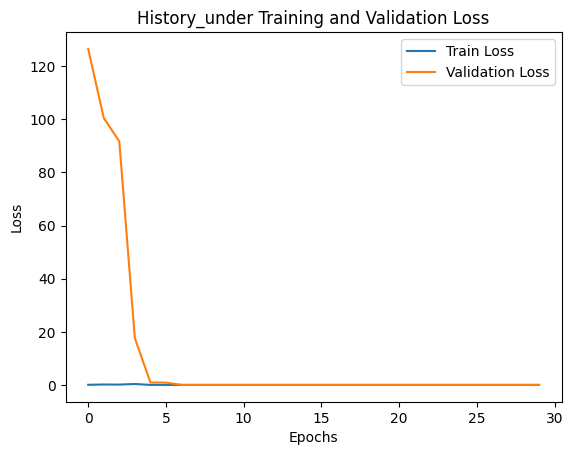

In [24]:
# 훈련 및 검증 손실 그래프
plt.plot(history_up.history['loss'], label='Train Loss')
plt.plot(history_up.history['val_loss'], label='Validation Loss')
plt.title('History_up Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 훈련 및 검증 손실 그래프
plt.plot(history_under.history['loss'], label='Train Loss')
plt.plot(history_under.history['val_loss'], label='Validation Loss')
plt.title('History_under Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

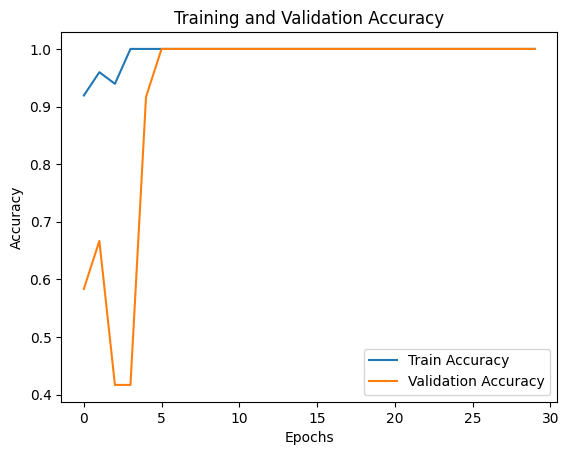

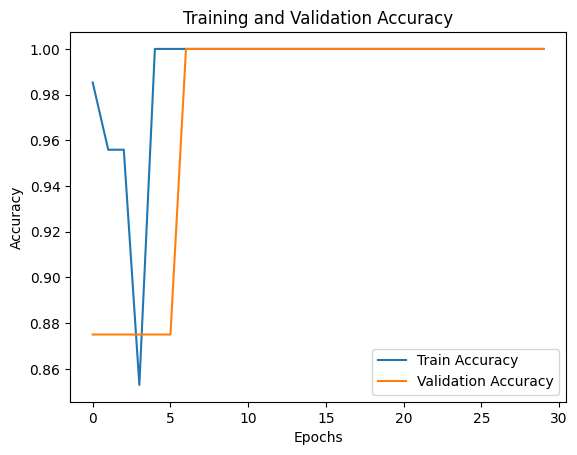

In [25]:
# 훈련 및 검증 정확도 그래프
plt.plot(history_up.history['accuracy'], label='Train Accuracy')
plt.plot(history_up.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 훈련 및 검증 정확도 그래프
plt.plot(history_under.history['accuracy'], label='Train Accuracy')
plt.plot(history_under.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
# Test 데이터
test_up_loss, test_up_accuracy = model.evaluate(X_test_up, y_test_up)
test_under_loss, test_under_accuracy = model.evaluate(X_test_under, y_test_under)


print("Up Test loss", test_up_loss)
print("Up test accuracy", test_up_accuracy)
print('------------------------------------------')
print("Under Test loss", test_under_loss)
print("Under Test accuracy", test_under_accuracy)

1/1 [==============================] - 1s 1s/step - loss: 3.1060e-05 - accuracy: 1.0000
Up Test loss 0.04888439178466797
Up test accuracy 1.0
------------------------------------------
Under Test loss 3.1059887987794355e-05
Under Test accuracy 1.0


# 분류할 이미지 넣기

## 이미지를 데이터화 시켜서 real_test에 넣기

In [36]:
real_test = preprocess_image('/content/drive/MyDrive/Project/photo1')

## 모델 추론

In [39]:
prediction = model.predict(real_test)
class_index = np.argmax(prediction)

# 분류 결과에 따라 이미지 저장

if class_index == 0:
  save_path = '/content/drive/MyDrive/Project/results/up_good'
elif class_index == 1:
  save_path = '/content/drive/MyDrive/Project/results/under_good'
elif class_index == 2:
  save_path = '/content/drive/MyDrive/Project/results/up_notgood'
else:
  save_path = '/content/drive/MyDrive/Project/results/uder_notgood'

# 저장할 폴더 내 이미지 파일들 개수 확인
file_list = os.listdir(save_path)
num_files = len(file_list)

# 이미지 저장
result_image = Image.fromarray(real_test[0])
result_image.save(os.path.join(save_path, f'results_{num_files + 1}.png'))

36/36 [==============================] - 16s 449ms/step


In [38]:
# 분류 결과에 따라 이미지 저장

if class_index == 0:
  save_path = '/content/drive/MyDrive/Project/results/up_good'
elif class_index == 1:
  save_path = '/content/drive/MyDrive/Project/results/under_good'
elif class_index == 2:
  save_path = '/content/drive/MyDrive/Project/results/up_notgood'
else:
  save_path = '/content/drive/MyDrive/Project/results/uder_notgood'

# 이미지 저장
result_image = Image.fromarray(real_test[0])
result_image.save(os.path.join(save_path, 'results.png'))